In [1]:
from PIL import Image


import numpy as np
import pandas as pd
import time
import pickle
import psycopg2 as pg
import pandas.io.sql as pd_sql
import sqlalchemy
from os import listdir
from os.path import isfile, join
import pathlib
import imageio
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
%matplotlib inline

In [2]:
# Read in the classes for the food-101 database

food_list = pd.read_csv('food-101/meta/classes.txt', header=None)
food_list.columns = ['food']

In [3]:
# read in the pathname for the image files. I started with small subsets as there are 101,000 images in 
# the database

image_list = []

for ii in range(0,len(food_list)):
    dir_to_image = 'food-101/images/' + food_list.at[ii, 'food']
    imgfiles = listdir(dir_to_image)
#    for img in imgfiles[:100]:
#   for img in imgfiles[:50]:
#    for img in imgfiles[:500]:
    for img in imgfiles:
        image_name = dir_to_image + '/' + img
        imagedata = [image_name, food_list.at[ii,'food']]
        image_list.append(imagedata)


        
images = pd.DataFrame(image_list, columns = ['imagePath','foodType'])

In [4]:
# read in which categories I labeled as "sweet"

labels = pd.read_csv('food-101/meta/sweet-label.txt', header=None)
labels.columns = ['foodType', 'label']

In [5]:
labeled_images = images.merge(labels, on='foodType')

In [6]:
labeled_images.head()

,imagePath,foodType,label
0,food-101/images/apple_pie/1873576.jpg,apple_pie,1
1,food-101/images/apple_pie/321197.jpg,apple_pie,1
2,food-101/images/apple_pie/2486622.jpg,apple_pie,1
3,food-101/images/apple_pie/631412.jpg,apple_pie,1
4,food-101/images/apple_pie/2189388.jpg,apple_pie,1


In [8]:
labeled_images.label.value_counts()

0    78000
1    22999
Name: label, dtype: int64

In [9]:
# As there is huge differences between the "sweet" and "not sweet" category, randomly undersample the larger
# category so they are the same

X = labeled_images.drop('label', axis=1).drop('foodType', axis=1)
y = labeled_images['label']
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,y)

In [11]:
len(y_under)

45998

In [13]:
# split into train and test. 

X_train, X_test, y_train, y_test = train_test_split(X_under, \
                                                    y_under, test_size=0.20, random_state=44)

X_train, X_cross, y_train, y_cross = train_test_split(X_train, \
                                                        y_train, test_size=0.25, random_state=44)

In [22]:
len(X_train)

27598

In [19]:
# Output for neural net. Originally I kept it in memory at a resize of 50 X 50 or 100 X 100 for analysis
# locally

counter = 1
for ii in range(0,len(X_train)):
    outfile = 'images/train/' + str(y_train[ii]) + '/' + str(counter) + '.jpg'

    img = imageio.imread(X_train[ii][0])
    imageio.imwrite(outfile, np.array(Image.fromarray(img).resize((224,224))))
    counter += 1

/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204800 bytes but only got 0. Skipping tag 55296
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25600 bytes but only got 0. Skipping tag 4096
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4291231744 bytes but only got 0. Skipping tag 65535
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3291283456 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlu

KeyboardInterrupt: 

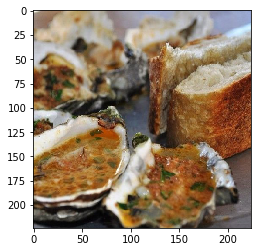

In [25]:
plt.imshow(Image.fromarray(img).resize((224,224)))


In [23]:

for ii in range(0,len(X_cross)):
    outfile = 'images/validate/' + str(y_cross[ii]) + '/' + str(counter) + '.jpg'

    img = imageio.imread(X_cross[ii][0])
    imageio.imwrite(outfile, np.array(Image.fromarray(img).resize((224,224))))
    counter += 1
    

/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 140378112 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204800 bytes but only got 0. Skipping tag 256
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25600 bytes but only got 0. Skipping tag 29440
  " Skipping tag %s" % (size, len(data), tag))


In [24]:

for ii in range(0,len(X_test)):
    outfile = 'images/test/' + str(y_cross[ii]) + '/' + str(counter) + '.jpg'

    img = imageio.imread(X_test[ii][0])
    imageio.imwrite(outfile, np.array(Image.fromarray(img).resize((224,224))))
    counter += 1

/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 204800 bytes but only got 0. Skipping tag 51968
  " Skipping tag %s" % (size, len(data), tag))
/home/grant/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:754: UserWarning: Possibly corrupt EXIF data.  Expecting to read 51200 bytes but only got 0. Skipping tag 38144
  " Skipping tag %s" % (size, len(data), tag))


In [ ]:
with open('data/large_images_X_values.pkl', 'wb') as to_write:
    pickle.dump(X_under, to_write)
with open('data/large_images_y_values.pkl', 'wb') as to_write:
    pickle.dump(y_under, to_write)

In [15]:
# Here I checked for non-color images. Turns out I had a picture of batman I needed to get rid of!

X_reshape = []
bad_values = []
for ii in range(0,len(X_under)):
    try: 
        X_reshape.append(np.array(X_under[ii][0].reshape((50*50*3))))
    except ValueError:
        print("Image " + str(ii) + " could not be reshaped! Look into it! Remove y value")
        bad_values.append(ii)
X_reshape = np.array(X_reshape)


In [16]:
X_reshape.shape

(45998, 7500)

In [19]:
for ii in range(len(bad_values) -1, -1, -1):
    y_under = np.delete(y_under, bad_values[ii])


In [17]:
y_under.shape

(45998,)

In [18]:
X_reshape.shape

(45998, 7500)

In [19]:
X_under = []


In [20]:
# Out pickle file for resized images so can read them in easily later.

with open('data/small_images_X_values.pkl', 'wb') as to_write:
    pickle.dump(X_reshape, to_write)
with open('data/small_images_y_values.pkl', 'wb') as to_write:
    pickle.dump(y_under, to_write)

In [21]:
# This split was for the original analysis, but I changed the code to output the images to directories for
# neural net analysis. Oops!

X_train, X_test, y_train, y_test = train_test_split(X_reshape, \
                                                    y_under, test_size=0.20, random_state=44)

X_train, X_cross, y_train, y_cross = train_test_split(X_train, \
                                                        y_train, test_size=0.25, random_state=44)

In [22]:
X_train.shape

(27598, 7500)

In [321]:
# Here I did logistic regression on several subsets of my data. Not the best predictor!

lm1 = LogisticRegression(C=1000)
lm1.fit(X_train, y_train)
reg_score = lm1.score(X_cross, y_cross)
print(reg_score)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5441304347826087


/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.5282608695652173 was LR result for 50x50 (50 images from each category)

0.5130434782608696 was LR result for 50x50 (100 images from each category)

0.5434782608695652 was LR result for 100x100 (50 images from each category)

0.5358695652173913 was LR result for 100x100 (100 images from each category)

0.5441304347826087 was LR result for 50x50 (500 images)


In [23]:
# This was decision tree for various dataset sizes

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_score = dtc.score(X_cross, y_cross)
print(dtc_score)

0.5510869565217391


0.508695652173913 was the result from the decision tree classifier for 300X300

0.5152173913043478 was the result from the decision tree classifier for 50x50 (50 images from each category)

0.5521739130434783 was the result from the decision tree classifier for 50x50 (100 images from each category)

0.5369565217391304 was the result from the decision tree classifier for 100x100 (50 images from each category)

0.55 was the result from the decision tree classifier for 100x100 (100 images from each category)

0.5365217391304348 was the result for 50x50 (500 images)

0.5510869565217391 was the result for 50x50 (1000 images)

In [24]:
# This was random forest for various dataset sizes, so I decided to go with this one for my final non-neural
# net predictor

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_score = rfc.score(X_cross, y_cross)
print(rfc_score)

0.628804347826087


0.5826086956521739 was the result from the random forest classifier for 300X300

0.6217391304347826 was the result from the random forest classifier for 50x50 (50 images from each category)

0.616304347826087 was the result from the random forest classifier for 50x50 (100 images from each category)

0.5826086956521739 was the result from the random forest classifier for 100x100( 50 images from each category)

0.6184782608695653 was the result from the random forest classifier for 100x100(100 images from each category)

0.6306521739130435 was the result from 50x50 (500 images)

0.628804347826087 was the result from 50x50 (1000 images)

In [28]:
# Checking the last run through of 1000 images to make sure testing and cross-validation where coming out
# similarly

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_score = rfc.score(X_test, y_test)
print(rfc_score)

0.6365217391304347


In [27]:
# Gaussian Naiive Bayes. Not the best, but it worked reasonably well. It seemed to run better with larger
# images.

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_score = gnb.score(X_cross, y_cross)
print(gnb_score)

0.5901086956521739


0.5804347826086956 was the result from the GNB for 50x50 (50 images from each category)
 
0.6032608695652174 was the result from the GNB for 50x50 (100 images from each category)

0.5804347826086956 was the result from the GNB for 100x100 (50 images from each cagetgory)

0.6043478260869565 was the result from the GNB for 100x100 (100 images)

0.5776086956521739 was the result for 50x50 (500 images)

0.5901086956521739 was the result for 50x50 (1000 images)


In [29]:
# Test on the last dataset

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_score = gnb.score(X_test, y_test)
print(gnb_score)

0.5933695652173913


In [ ]:
# Support vector machine with rbf. VERY BAD!

svc = SVC(cache_size=20000)
svc.fit(X_train, y_train)
svc_score = svc.score(X_cross, y_cross)
print(svc_score)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.4891304347826087 was SVC result for 50x50 (50 images from each category)

0.5021739130434782 was SVC result for 50x50 (100 images from each category)

0.4891304347826087 was SVC result for 100x100 (50 images from each category)

0.5021739130434782 was SVC result for 100x100 (100 images from each category)

In [ ]:
# Polynomial slighty better, but still bad, and these take ages to run.

svc = SVC(kernel='poly')
svc.fit(X_train, y_train)
svc_score = svc.score(X_cross, y_cross)
print(svc_score)

/home/grant/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5532608695652174 for 100x100 (100 images)
 

In [142]:
# HEre I ran knn for the smallest dataset just to check. Not the best, and it took AGES! 


accuracy = np.zeros(20)
for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reshape, y_train)
    y_pred = knn.predict(X_cross)
    accuracy[k-1]=accuracy_score(y_cross, y_pred)

In [143]:
accuracy

array([0.50869565, 0.51956522, 0.5       , 0.51086957, 0.52391304,
       0.54347826, 0.52173913, 0.53478261, 0.53695652, 0.53913043,
       0.54565217, 0.52826087, 0.55      , 0.52173913, 0.5326087 ,
       0.53478261, 0.56304348, 0.55434783, 0.57391304, 0.55869565])

array([0.50869565, 0.51956522, 0.5       , 0.51086957, 0.52391304,
       0.54347826, 0.52173913, 0.53478261, 0.53695652, 0.53913043,
       0.54565217, 0.52826087, 0.55      , 0.52173913, 0.5326087 ,
       0.53478261, 0.56304348, 0.55434783, 0.57391304, 0.55869565])